## Imports

> **Note:** Merging training and validation data to increase the training data. For validation, testing data will be used and we can use real life examples for making prediction.

In [1]:
import gradio as gr
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
import spacy
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from timeit import default_timer as timer
from helper_functions import plot_pie_chart, preprocess_text, plot_training_history, preprocess_single_sentence
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

/Users/kushagrakesarwani/Documents/Emotion Detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kushagrakesarwani/Documents/Emotion Detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DIR= 'kaggle/input/emotion-dataset-for-nlp/'
TRAIN_FILE = 'train.txt'
VAL_FILE = 'val.txt'
TEST_FILE = 'test.txt'

In [3]:
train_df = pd.read_csv(DIR+TRAIN_FILE, delimiter=';', header=None, names=['text', 'label'])
val_df = pd.read_csv(DIR+VAL_FILE, delimiter=';', header=None, names=['text', 'label'])
test_df = pd.read_csv(DIR+TEST_FILE, delimiter=';', header=None, names=['text', 'label'])

In [4]:
val_df.info(), train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


(None, None)

In [5]:
train_df = pd.concat([train_df, val_df], ignore_index=True)
del( val_df)

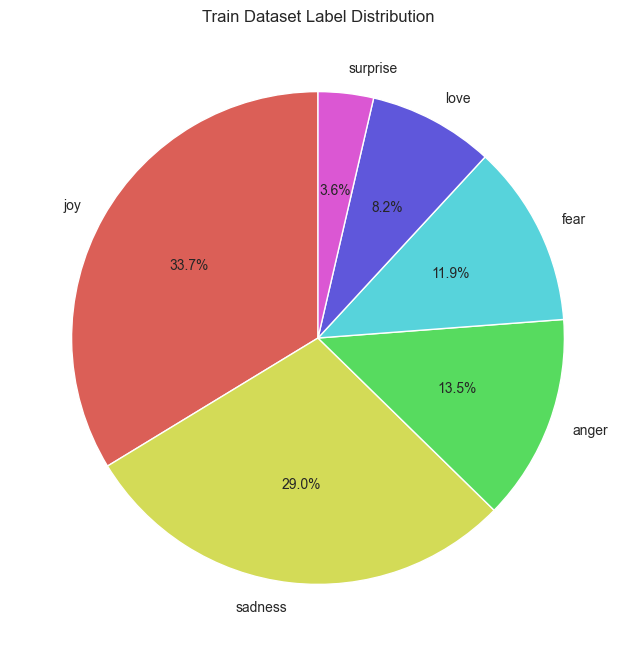

In [6]:
plot_pie_chart(train_df, 'Train Dataset')

## Preprocessing

In [7]:
train_df['label']= train_df['label'].str.replace('love', 'joy')
test_df['label']= test_df['label'].str.replace('love', 'joy')

In [8]:
train_df= preprocess_text(train_df)
test_df= preprocess_text(test_df)

In [ ]:
plot_pie_chart(train_df, 'New Train Data')

In [ ]:
train_df.info()

## Visualisation

In [ ]:
with open('kaggle/label_names.txt', 'r') as f:
    labels = [emotion.strip() for emotion in f.readlines()] 

encoder= LabelEncoder()
encoder.fit(labels)

# Generate and plot word cloud for each label
for class_label, text in zip(labels, train_df['processed_text']):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {class_label}')
    plt.axis('off')
    plt.show()


## Model

In [ ]:
VOCAB_SIZE= 11000
text_vect_layer= tf.keras.layers.TextVectorization(max_tokens= VOCAB_SIZE)
text_vect_layer.adapt(train_df['processed_text'])

In [ ]:
EMBEDDING_UNITS= 32
UNITS= 32
DROPOUT= 0.2

model_v1= tf.keras.Sequential([
    text_vect_layer,
    layers.Embedding(input_dim=text_vect_layer.vocabulary_size(), output_dim= EMBEDDING_UNITS, mask_zero= True),
    layers.GRU(UNITS, dropout= DROPOUT),
    layers.Dense(len(labels), activation= 'sigmoid')
])

model_v2= tf.keras.Sequential([
    text_vect_layer,
    layers.Embedding(input_dim=text_vect_layer.vocabulary_size(), output_dim= EMBEDDING_UNITS, mask_zero= True),
    layers.LSTM(UNITS, dropout= DROPOUT),
    layers.Dense(len(labels), activation= 'sigmoid')
])


In [ ]:
model_v1.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
model_v2.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

In [ ]:
GRU_MODEL= 'models/best_gru_model.keras'
LSTM_MODEL= 'models/best_lstm_model.keras'

gru_checkpoint_callback = ModelCheckpoint(filepath=GRU_MODEL,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      mode='max',
                                      verbose=1)

lstm_checkpoint_callback = ModelCheckpoint(filepath=LSTM_MODEL,
                                           monitor='val_accuracy',
                                           save_best_only=True,
                                           mode='max',
                                           verbose=1)

In [ ]:
BATCH_SIZE= 64
train_set= tf.data.Dataset.from_tensor_slices((train_df['processed_text'].values, train_df['label_num'].values)).batch(BATCH_SIZE)
test_set= tf.data.Dataset.from_tensor_slices((test_df['processed_text'].values, test_df['label_num'].values)).batch(BATCH_SIZE)

In [ ]:
EPOCHS= 5
history_model_v1= model_v1.fit(train_set,
                               validation_data= test_set,
                               epochs= EPOCHS,
                               callbacks= [gru_checkpoint_callback])

In [ ]:
history_model_v2= model_v2.fit(train_set,
                               validation_data= test_set, 
                               epochs= EPOCHS,
                               callbacks= [lstm_checkpoint_callback])

## Plotting the losses and accuracy

In [ ]:
plot_training_history(history_model_v1)

In [ ]:
plot_training_history(history_model_v2)

## Evaluate the model

In [ ]:
def evaluate_true_vs_predicted(true_labels, predicted_labels):
    """
    Evaluates the true versus predicted labels using accuracy and confusion matrix.

    Parameters:
    true_labels (numpy array): Array containing true labels.
    predicted_labels (numpy array): Array containing predicted labels.

    Returns:
    accuracy (float): Accuracy of the predictions.
    confusion_mat (numpy array): Confusion matrix.
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    return accuracy, confusion_mat

In [ ]:
del(model_v1, model_v2)

In [ ]:
model_v1 = tf.keras.models.load_model(GRU_MODEL)

In [ ]:
test_df.reset_index(drop=True, inplace= True)
true_labels= test_df['label_num']
pred_labels= []
for i in range(len(true_labels)):
    sample_text= test_df['processed_text'][i]
    sample_text= tf.expand_dims(sample_text, 0)
    prob= model_v1.predict(sample_text)
    prob= prob[0]
    pred_label= np.argmax(prob)
    pred_labels.append(pred_label)

In [ ]:
accuracy, confusion_mat = evaluate_true_vs_predicted(true_labels, predicted_labels=pred_labels)
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_mat, annot=True, cmap='coolwarm')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
comparison_df = pd.DataFrame({
    'True_Label': encoder.inverse_transform(true_labels),
    'Predicted_Label': encoder.inverse_transform(pred_labels),
    'Text': test_df['processed_text'] 
})

wrong_predictions_df = comparison_df[comparison_df['True_Label'] != comparison_df['Predicted_Label']]

print("Wrongly Predicted Labels vs. True Labels:")
wrong_predictions_df

## Predictions for a single sentence
To make predictions on a single sentence, we need to do the following steps:
1. Process it in the same manner to remove the extra token words such (as punctuations)
2. Expand the dimension.
3. Pass through the model.

In [ ]:
with open('kaggle/examples.txt', 'r') as f:
    example_list = [example.strip() for example in f.readlines()]

encoder= LabelEncoder()
encoder.fit(labels) 

nlp = spacy.load("en_core_web_sm")

def predict(text):
    """
    Make predictions on the given text using the trained model.

    Args:
        text (str): The text to make predictions on.

    Returns:
        list: A list of predictions.
    """
    start_time= timer()
    text= preprocess_single_sentence(text)
    text= tf.expand_dims(text, 0)

    probability = model_v1.predict(text)
    pred_label_with_prob= {labels[i]: float(probability[0][i]) for i in range(len(labels))} 
    pred_time = round(timer() - start_time, 5)
    return pred_label_with_prob, pred_time

### Gradio App
input= gr.Textbox(lines=5, label="Enter text", placeholder="i like to have the same breathless feeling as a reader eager to see what will happen next")
outputs=[
        gr.Label(num_top_classes=len(labels), label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ]
title= ' Sentiment Analysis 🤣😱😡😢 '
description= 'The sentiment analysis model is a deep learning-based natural language processing (NLP) model designed to analyze and classify the sentiment expressed in text data. It is trained to understand the emotional tone of text and categorize it into predefined sentiment categories such as <b>anger, fear, saddness and joy.<b>'
demo= gr.Interface(fn=predict, 
                   inputs=input, 
                   outputs=outputs, 
                   title=title, 
                   description=description,
                   examples= example_list
                  )
demo.launch()